# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

**Цель проекта** - построить модель, которая умеет предсказывать рыночную стоимость автомобиля. 

Предсказание будет основано на данных предоставленных заказчиком - технических характеристиках, комплектации и ценах других автомобилей.

Критерии для выбора модели прогнозирования, основанные на запросах заказчика:
- качество предсказания - значение метрики RMSE должно быть меньше 2500 ;
- время обучения модели;
- время предсказания модели.

Для исследования предоставлена таблица `autos.csv` с данными об автомобилях из объявлений сервиса.

Этапы исследования:
1. Обзор данных
2. Предобработка данных
3. Разведочный анализ данных
4. Подбор модели и прогнозирование
5. Интерпретация результатов и выводы

## 1. Обзор данных 

Импортируем библиотеки, скачаем данные и посмотрим их и оценим соответствуют ли они задаче. 

In [1]:
! pip install phik -q
! pip install Levenshtein -q
! pip install -U scikit-learn -q

In [2]:
import os
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder , StandardScaler, OrdinalEncoder
from sklearn.metrics import (mean_absolute_error, mean_squared_error , r2_score, recall_score, accuracy_score, precision_score, confusion_matrix, 
roc_auc_score, f1_score, make_scorer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import lightgbm as lgb

import phik
from Levenshtein import distance 
from datetime import date

RANDOM_STATE = 42
sns.set_palette("pastel")

In [3]:
if os.path.exists('../Downloads/autos.csv'):
    autos = pd.read_csv('../Downloads/autos.csv')
elif os.path.exists('/datasets/autos.csv'):
    autos = pd.read_csv('/datasets/autos.csv')
else:
    print('Something is wrong')

In [4]:
autos.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
148491,2016-03-22 11:48:24,2300,wagon,1988,auto,0,3er,90000,7,petrol,bmw,NaN,2016-03-22 00:00:00,0,86316,2016-03-26 12:45:03
70534,2016-03-18 22:46:29,0,small,2002,auto,41,fortwo,150000,8,gasoline,smart,no,2016-03-18 00:00:00,0,28816,2016-03-26 11:46:51
349107,2016-03-08 21:56:46,1399,sedan,1998,manual,75,golf,150000,10,petrol,volkswagen,NaN,2016-03-08 00:00:00,0,24537,2016-03-12 13:45:42
226691,2016-03-12 10:55:12,14500,sedan,2007,manual,177,5er,150000,12,gasoline,bmw,no,2016-03-12 00:00:00,0,30539,2016-04-06 02:46:45
2925,2016-04-01 12:49:00,11300,wagon,2010,auto,160,a4,150000,12,petrol,audi,no,2016-04-01 00:00:00,0,47475,2016-04-07 09:17:47


In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В таблице 16 параметров и 354369 записей. Семь признаков относятся к целочисленному типу данных. Три признака - даты, остальные - категориальные данные.

В колонках `VehicleType`, ` Gearbox`, `Model`, `FuelType`, `Repaired`  есть пропуски.

In [6]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В колонке `NumberOfPictures` все данные имеют одинаковое значение - 0. То есть ни для одного объявления нет фото автомобиля. Этот признак неинформативен для исследования.

In [7]:
autos.NumberOfPictures.value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

In [8]:
autos = autos.drop("NumberOfPictures", axis =1)

### Вывод
1. В таблице `autos.csv` 16 параметров и 354369 записей. Данные соответствуют описанию задачи.
Характеристики, представленные в таблице:

- `DateCrawled` — дата скачивания анкеты из базы;
- `VehicleType` — тип автомобильного кузова;
- `RegistrationYear` — год регистрации автомобиля;
- `Gearbox` — тип коробки передач;
- `Power` —  мощность (л. с.);
- `Model` — модель автомобиля;
- `Kilometer` — пробег (км);
- `RegistrationMonth` — месяц регистрации автомобиля;
- `FuelType` — тип топлива;
- `Brand` — марка автомобиля;
- `Repaired` — была машина в ремонте или нет;
- `DateCreated` — дата создания анкеты;
- `NumberOfPictures` — количество фотографий автомобиля;
- `PostalCode` — почтовый индекс владельца анкеты (пользователя);
- `LastSeen` — дата последней активности пользователя;
- `Price` - стоимость автомобиля в евро, целевой признак

2. В пяти колонках таблицы есть пропуски. 
3. `NumberOfPictures` неинформативный признак , т.к. среди представленных для анализа данных он не изменяется - для всех записей значение 0. Его удалили.
4. В колонке с годом регистрации есть аномальные невозможные значения (9999Б 1000 и другие), с ними разберемся на этапе EDA.

## 2. Предобработка данных

### 2.1 Пропуски


In [9]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

**Model**

заполнить какими-либо контретными данными эти пропуски невозможно. Создадим для них категорию - `unknown`.

In [10]:
autos.Model.value_counts().head(15)

golf        29232
other       24421
3er         19761
polo        13066
corsa       12570
astra       10809
passat      10146
a4           9900
c_klasse     8312
5er          7868
e_klasse     6785
a3           6122
focus        5874
fiesta       5774
a6           5541
Name: Model, dtype: int64

In [11]:
autos.Model = autos.Model.fillna('unknown')

**VehicleType**

In [12]:
autos.VehicleType.value_counts()        


sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Среди типов кузова - седан, small (что-то вроде хетчбэк, предполагаю), фургон, автобус, кабриолет, купе, внедорожник и группа определенных как другие.

In [13]:
autos[autos.VehicleType.isna()].sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
12596,2016-03-29 16:50:59,400,NaN,2016,manual,0,ibiza,150000,5,petrol,seat,yes,2016-03-29 00:00:00,49134,2016-04-06 02:44:57
108325,2016-03-19 15:47:43,0,NaN,2005,manual,0,transporter,150000,10,gasoline,volkswagen,NaN,2016-03-19 00:00:00,39118,2016-04-07 00:17:14
336335,2016-03-28 16:50:58,1900,NaN,2017,manual,75,astra,150000,0,NaN,opel,no,2016-03-28 00:00:00,44625,2016-04-06 22:17:42
321313,2016-04-04 15:44:27,6000,NaN,2016,manual,105,golf,150000,10,gasoline,volkswagen,no,2016-04-04 00:00:00,53489,2016-04-06 17:15:31
196231,2016-03-08 15:54:17,140,NaN,1960,NaN,0,unknown,5000,1,NaN,sonstige_autos,NaN,2016-03-08 00:00:00,27446,2016-04-04 21:45:39


In [14]:
autos[(autos.Brand=='volvo')& (autos.Model == 'v50')].sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
171495,2016-03-28 16:38:02,4000,wagon,2004,manual,136,v50,150000,6,gasoline,volvo,no,2016-03-28 00:00:00,97464,2016-04-06 21:44:53
210226,2016-04-03 16:44:55,6000,wagon,2005,manual,136,v50,150000,2,gasoline,volvo,no,2016-04-03 00:00:00,56727,2016-04-05 15:47:04
75729,2016-03-07 23:37:21,9800,wagon,2008,auto,179,v50,150000,3,gasoline,volvo,no,2016-03-07 00:00:00,79117,2016-03-29 03:47:00
189334,2016-04-03 23:06:23,5975,wagon,2007,manual,136,v50,150000,8,gasoline,volvo,no,2016-04-03 00:00:00,65428,2016-04-05 12:13:01
189975,2016-03-22 12:38:43,7800,wagon,2011,manual,114,v50,70000,10,gasoline,volvo,yes,2016-03-22 00:00:00,53797,2016-03-22 12:38:43
143357,2016-03-09 15:55:48,6999,wagon,2007,manual,110,v50,125000,6,gasoline,volvo,no,2016-03-09 00:00:00,85057,2016-04-07 01:45:16
127872,2016-03-22 02:36:35,4000,wagon,2005,manual,136,v50,150000,10,gasoline,volvo,no,2016-03-22 00:00:00,12351,2016-04-05 16:47:11
293208,2016-03-07 14:54:57,8450,wagon,2009,manual,136,v50,150000,2,gasoline,volvo,no,2016-03-07 00:00:00,63071,2016-04-07 06:46:08
226551,2016-04-04 11:51:33,5000,NaN,2016,manual,136,v50,150000,6,NaN,volvo,no,2016-04-04 00:00:00,47169,2016-04-06 12:47:02
341077,2016-03-29 20:56:18,3500,wagon,2005,manual,140,v50,150000,6,gasoline,volvo,NaN,2016-03-29 00:00:00,51465,2016-03-31 14:45:59


Пропуски нужно чем-то закрыть или убрать. Убрать - значит лишиться 10% и более данных, это слишком много. Проигнорировать их мы тоже не можем - наличие пропусков будет мечать машинному обучению.

Можно либо (1) заполнить пропуски наиболее распространенным значением в группах марка-модель (хотя обычно для модели можно выбрать тип кузова), либо (2) присвоить категорию `unknown` пропущенным значениям. 

Попробуем использовать первый вариант.

In [15]:
# autos['VehicleType'] = autos['VehicleType'].fillna(autos.groupby('Model')['VehicleType'].transform('mode'))
autos['VehicleType'] = autos.groupby(['Model'])['VehicleType'].apply(lambda x: x.fillna(x.value_counts().index[0]))


In [16]:
autos.VehicleType.isna().sum()

0

In [17]:
autos.VehicleType.value_counts()

sedan          112600
small           88586
wagon           68535
bus             31882
convertible     20458
coupe           16555
suv             12462
other            3291
Name: VehicleType, dtype: int64

**GearBox**

 На основе имеющихся данных невозможно заполнить пропуски конкретными значениями типов коробки передач. Пропуски добавим в отдельную категорию `unknown``

In [18]:
autos.Gearbox.value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [19]:
autos.Gearbox = autos.Gearbox.fillna('unknown')

**FuelType**

In [20]:
autos.FuelType.value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Petrol и gasoline - одно и то же. Нужно исправить (см ниже в неявных дубликатах).
Пропуски запоним самым распространенным значением - `petrol`

In [21]:
autos.FuelType = autos.FuelType.fillna('petrol')

print(autos.FuelType.value_counts())
autos.FuelType.isna().sum()

petrol      249247
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64


0

**Repaired**

In [22]:
autos.Repaired.value_counts()

no     247161
yes     36054
Name: Repaired, dtype: int64

Скорее всего пропуск в этой колонке означает, что автомобиль не был в ремонте. В ходе хаполнения анкеты пользователь мог просто проигнорировать это поле, если машину не ремонтировали.
Заменим пропуск на `no`.

In [23]:
autos.Repaired = autos.Repaired.fillna('no')
autos.Repaired.value_counts()

no     318315
yes     36054
Name: Repaired, dtype: int64

### 2.2 Дубликаты 

- проверим на неявные дубликаты и ошибки

Заменим `gasoline` на `petrol` в колонке FuelType

In [24]:
autos.FuelType = autos.FuelType.replace('gasoline', 'petrol')
autos.FuelType.value_counts()

petrol      347967
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Воспользуемся расстоянием Левенштейна, чтобы найти ошибки и неявные дубликаты в столбцах с большим числом наименований - с марками и моделями автомобилей.

In [25]:

def findAlmostDuplicates(df, column):
    duplicates = []
    for i in range(df[column].nunique()):
        for j in range(i+1, df[column].nunique()):
            result = distance(df[column].unique()[i], df[column].unique()[j])
            if result < 2:
                duplicates.extend([df[column].unique()[i], df[column].unique()[j]])
    return duplicates



In [26]:
brand_duplicates = findAlmostDuplicates(autos, 'Brand')
brand_duplicates

[]

В названиях марок автомобилей нет дубликатов. 

In [27]:
autos.Model = autos.Model.astype(str)
for name in autos.Brand.unique():
    df = autos[autos.Brand ==name ]
    result = findAlmostDuplicates(df, 'Model')
    print(f''' {name} : {set(result)}''')


 volkswagen : set()
 audi : {'a5', 'a2', '90', 'a3', 'q3', '100', 'a8', 'a1', 'a4', '80', 'q5', 'q7', '200', 'a6'}
 jeep : set()
 skoda : set()
 bmw : {'1er', '5er', 'z_reihe', 'm_reihe', 'x_reihe', '7er', '6er', '3er'}
 peugeot : {'1_reihe', '2_reihe', '5_reihe', '3_reihe', '4_reihe'}
 ford : {'s_max', 'c_max', 'b_max'}
 mazda : {'6_reihe', 'cx_reihe', '1_reihe', '5_reihe', '3_reihe', 'rx_reihe', 'mx_reihe'}
 nissan : set()
 renault : set()
 mercedes_benz : {'sl', 'slk', 's_klasse', 'cl', 'clk', 'v_klasse', 'g_klasse', 'e_klasse', 'glk', 'gl', 'c_klasse', 'a_klasse', 'm_klasse', 'b_klasse'}
 opel : set()
 seat : set()
 citroen : {'c2', 'c3', 'c5', 'c4', 'c1'}
 honda : set()
 fiat : set()
 mini : set()
 smart : set()
 hyundai : set()
 sonstige_autos : set()
 alfa_romeo : {'147', '145', '159', '156'}
 subaru : set()
 volvo : {'c_reihe', 'v70', 'xc_reihe', 's60', 'v60', 'v40', '850', 'v50'}
 mitsubishi : set()
 kia : set()
 suzuki : set()
 lancia : set()
 toyota : set()
 chevrolet : set(

В названиях моделей, вроде бы, тоже нет ошибок и неявных дубликатов. То, что выявилось в проверке - разные модели модели автомобилей.

- строки-дубликаты

In [28]:
print(autos.duplicated().sum())
autos_new = autos.drop_duplicates()
autos.shape[0]-autos_new.shape[0]

5


5

В таблице 5 записей-дубликатов. Их удалили.

### 2.3 Изменение типа данных

Изменим тип данных дат на datetime для удобства работы с ними. Кроме того, уберем часы и дни, т.к. нам они не понадобятся для исследования.

In [29]:
dates = ['DateCrawled', 'LastSeen',  'DateCreated']

for el in dates:
      autos_new[el] = pd.to_datetime(autos_new[el], format='%Y-%m-%d').dt.date

autos_new.sample()


C:\Users\very-\AppData\Local\Temp/ipykernel_12708/2956463796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autos_new[el] = pd.to_datetime(autos_new[el], format='%Y-%m-%d').dt.date


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
179534,2016-03-19,11000,suv,2009,manual,173,cx_reihe,150000,12,petrol,mazda,no,2016-03-19,18299,2016-04-06


### 2.4 Добавление столбцов
1. Месяц создания объявления о продаже

In [30]:
autos_new['DateCreated_month'] = pd.DatetimeIndex(autos_new.DateCreated).month

C:\Users\very-\AppData\Local\Temp/ipykernel_12708/371440311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autos_new['DateCreated_month'] = pd.DatetimeIndex(autos_new.DateCreated).month


In [31]:
autos_new.sample()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,DateCreated_month
96151,2016-03-11,1350,small,2005,manual,95,punto,125000,3,petrol,fiat,yes,2016-03-11,88131,2016-03-12,3


2. Время с появления объявления до последней активности пользователя

In [32]:
autos_new['days_from_first_to_last'] = (autos_new['LastSeen'] - autos_new['DateCreated']).dt.days
autos_new.sample(3)

C:\Users\very-\AppData\Local\Temp/ipykernel_12708/2276964062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autos_new['days_from_first_to_last'] = (autos_new['LastSeen'] - autos_new['DateCreated']).dt.days


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,DateCreated_month,days_from_first_to_last
139811,2016-03-27,1399,wagon,2018,unknown,0,caddy,150000,0,petrol,volkswagen,no,2016-03-27,34613,2016-03-27,3,0
14423,2016-03-19,5000,wagon,2010,manual,87,other,100000,7,lpg,dacia,yes,2016-03-19,72108,2016-04-07,3,19
339256,2016-03-28,10300,small,2010,manual,122,cooper,125000,6,petrol,mini,no,2016-03-28,83646,2016-04-07,3,10


### Вывод

1. Пропуски:
-  в колонке с типом кузова заменили на самые распространенные значения в группах по модели машины.
-  в колонках с типом коробки передач, с моделью авто заполнили категорией `unknown`
-  в колонке с инфо о проведении ремонта авто заполнили категорией `no`
-  в колонке с типом топлива отнесли к самой распространенной категории `petrol`

2. Дубликаты и ошибки:
- в колонке с типом топлива убрали категорию  gasoline, и отнесли сооответвующие записи к категории petrol. 
- удалили строки-дубликаты

- Изменили тип данных дат

- добавили колонки с месяцем появления объявления и днями между появлением объявления и последний активностью пользователя.

## 3. Разведочный анализ

In [33]:
autos_new.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,DateCreated_month,days_from_first_to_last
count,354364,354364.000000,354364,354364.000000,354364,354364.000000,354364,354364.000000,354364.000000,354364,354364,354364,354364,354364.000000,354364,354364.000000,354364.000000
unique,34,NaN,8,NaN,3,NaN,251,NaN,NaN,6,40,2,109,NaN,34,NaN,NaN
top,2016-04-03,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03,NaN,2016-04-06,NaN,NaN
freq,13668,NaN,112599,NaN,268248,NaN,29232,NaN,NaN,347962,77012,318311,13718,NaN,75616,NaN,NaN
mean,NaN,4416.655608,NaN,2004.234471,NaN,110.093723,NaN,128211.373051,5.714641,NaN,NaN,NaN,NaN,50508.461698,NaN,3.160186,8.678080
std,NaN,4514.159690,NaN,90.228593,NaN,189.851590,NaN,37905.136957,3.726433,NaN,NaN,NaN,NaN,25783.124276,NaN,0.376281,8.639417
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,1067.000000,NaN,1.000000,0.000000
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,30165.000000,NaN,3.000000,2.000000
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,49409.500000,NaN,3.000000,6.000000
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,71083.000000,NaN,3.000000,13.000000


In [34]:
def hist_for_nums(data, cols, bins = 100):
    for col, ax in zip(cols, axs.ravel()):
        sns.histplot(data = data[col], ax=ax, bins = bins )
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel('Число объявлений')

In [35]:
def box_for_nums(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.boxplot(data = data[col].values, ax=ax)
        ax.set_title(col)
        ax.set_ylabel(col)

In [36]:
def count_for_cat(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.countplot(x=data[col], data=data, order=data[col].value_counts().index, ax=ax)
        ax.set_title(col)
        ax.set_ylabel('Число объявлений')
        for i, v in enumerate(data[col].value_counts()):
            ax.text(i, v, str(v), ha='center')

### 3.1 Стоимость, пробег, мощность

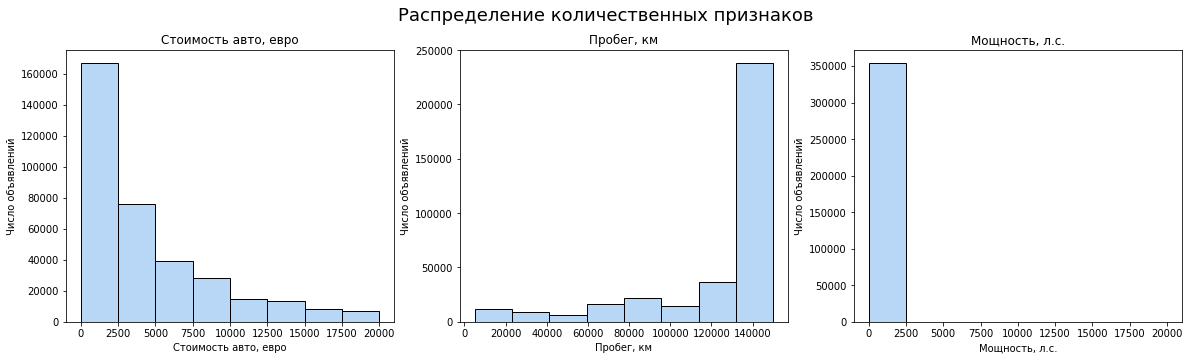

In [37]:
num_columns = ['Price', 'Kilometer', 'Power']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle('Распределение количественных признаков' , fontsize=18,  y=1)
hist_for_nums(autos_new,num_columns, bins = 8)

axs[0].set_title("Стоимость авто, евро")
axs[0].set_xlabel("Стоимость авто, евро")

axs[1].set_title("Пробег, км")
axs[1].set_xlabel('Пробег, км')

axs[2].set_title("Мощность, л.с.")
axs[2].set_xlabel('Мощность, л.с.');

(0.0, 300.0)

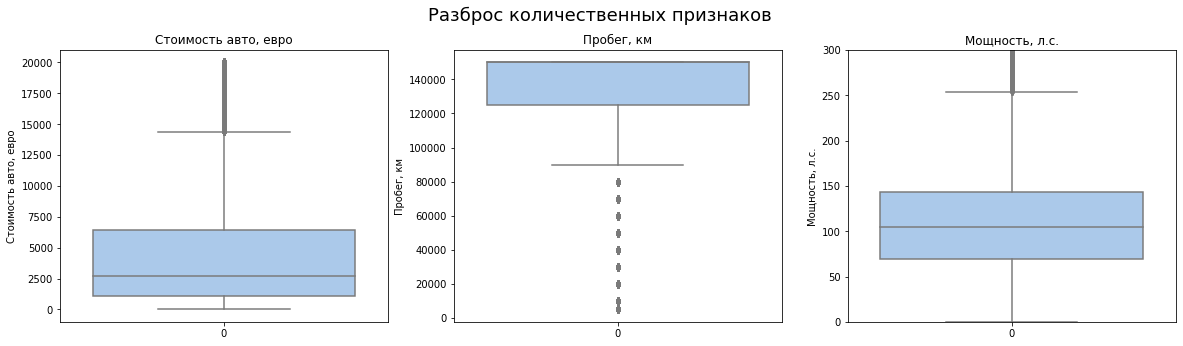

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle('Разброс количественных признаков' , fontsize=18,  y=1)
box_for_nums(autos_new,num_columns)

axs[0].set_title("Стоимость авто, евро")
axs[0].set_ylabel("Стоимость авто, евро")

axs[1].set_title("Пробег, км")
axs[1].set_ylabel('Пробег, км')

axs[2].set_title("Мощность, л.с.")
axs[2].set_ylabel('Мощность, л.с.')
axs[2].set_ylim(0, 300)


- Стоимость авто в большинстве объявлений менее 7500 евро. Однако есть и сильно более дорогие авто.
- В основном, прожают машины с большим пробегом ~ 140000 км. Это похоже на правду.
- Средняя мощность авто в объявлениях составляет около 100 лошадиных сил. Здесь есть аномалии. Встречаются какие-то нереальные мощности - более 500 л.с (что характерно для спорткаров). Самые мощные авто не имеют больше 1500 л.с. Удалим записи с мощностью более 500 л.с. (их около 500)

In [39]:
shape_old = autos_new.shape[0]
autos_new = autos_new[autos_new.Power < 500]
#удалили процентов записей
(shape_old-autos_new.shape[0])/shape_old*100

0.14053346276709822

### 3.2 Категориальные данные

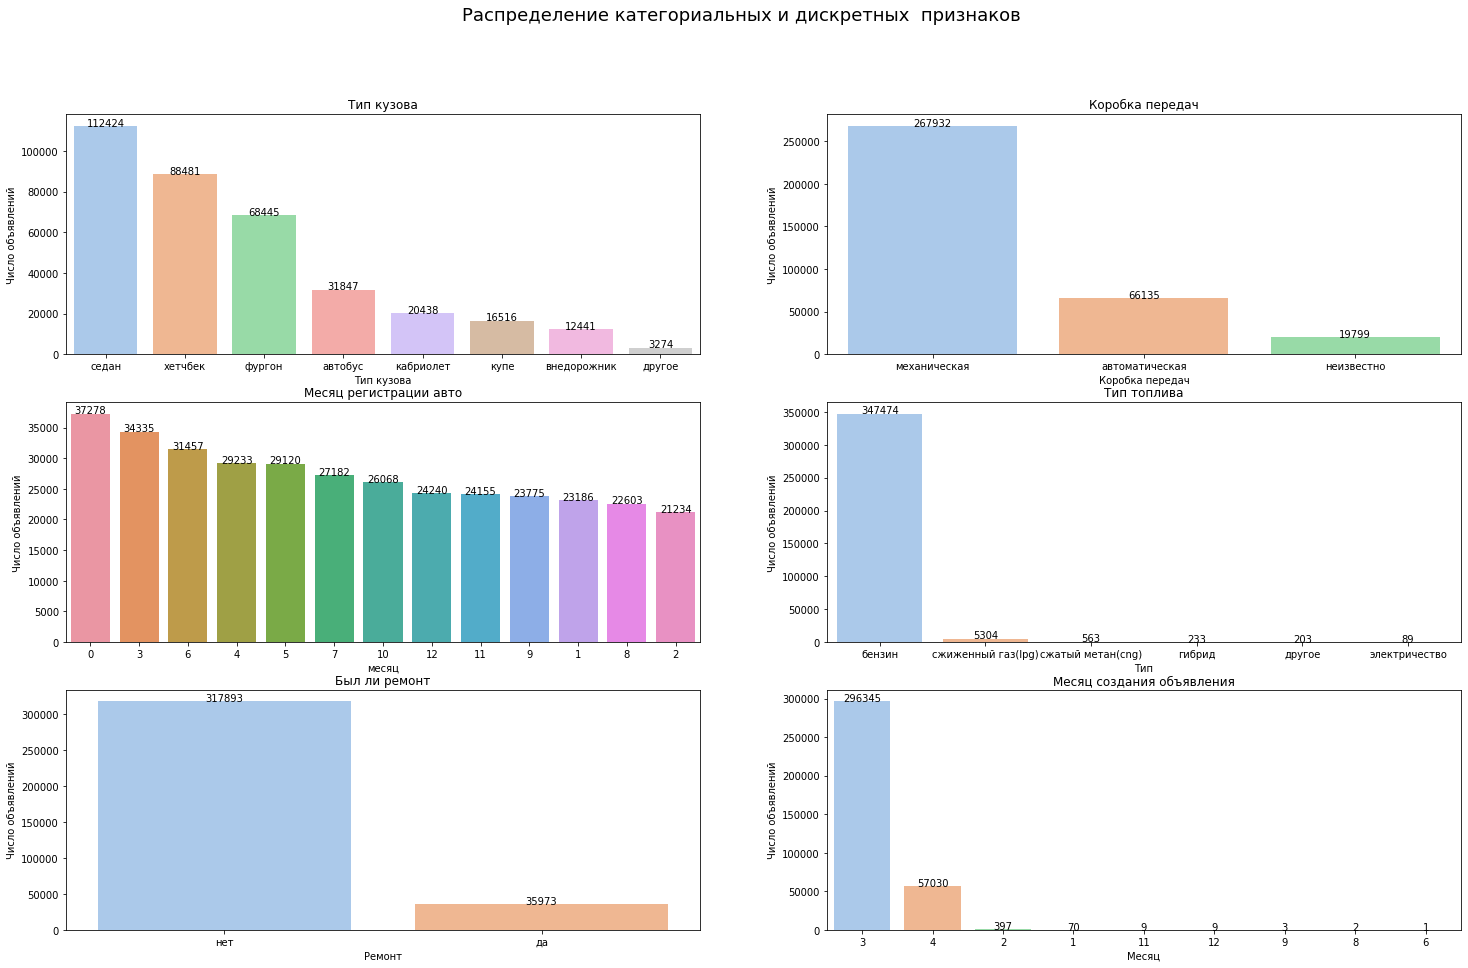

In [40]:
cat_columns = ['VehicleType','Gearbox', 'RegistrationMonth', 'FuelType'	, 'Repaired', 'DateCreated_month']
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(25, 15))
fig.suptitle('Распределение категориальных и дискретных  признаков' , fontsize=18)
count_for_cat(autos_new,cat_columns)

axs[0,0].set_title("Тип кузова")
axs[0,0].set_xlabel("Тип кузова")
axs[0,0].set_xticklabels(["седан", "хетчбек", "фургон", "автобус", "кабриолет", "купе", "внедорожник", "другое"])

axs[0,1].set_title("Коробка передач")
axs[0,1].set_xlabel('Коробка передач')
axs[0,1].set_xticklabels(["механическая", "автоматическая", "неизвестно"])

axs[1,0].set_title("Месяц регистрации авто")
axs[1,0].set_xlabel('месяц')

axs[1,1].set_title("Тип топлива")
axs[1,1].set_xlabel('Тип')
axs[1,1].set_xticklabels(["бензин", "сжиженный газ(lpg)", "сжатый метан(cng)","гибрид", "другое", "электричество"])

axs[2,0].set_title("Был ли ремонт")
axs[2,0].set_xlabel('Ремонт')
axs[2,0].set_xticklabels(["нет", "да"])

axs[2,1].set_title("Месяц создания объявления")
axs[2,1].set_xlabel('Месяц') ;

- Больше всего среди объявлений авто типа седан, хетчбек и фургон.
- Большинство авто с механической коробкой передач
- Авто распределены более менее равномерно по месяцам регистрации в течение года. Аномальное значение - 0. Месяц регистрации неинформативный признак. 
- Большинство автомобилей работают на бензине (практически абсолютное большинство, на это также повлияло заполнение пропусков)
- Большинство автомобилей не были в ремонте (заполнение пропусков тоже повлияло)
- Практически все объявления были сформированы в марте и апреле

### 3.3 Марка и модель авто

Выведем топ-15 марок и моделей из объявлений

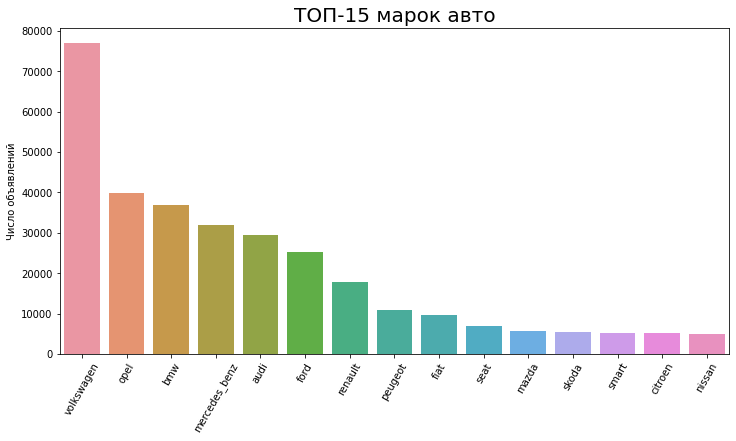

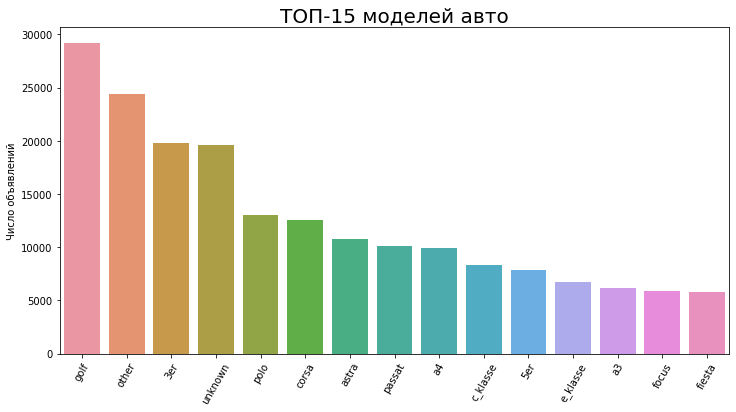

In [41]:
plt.figure(figsize=(12, 6))
top_brands = autos_new['Brand'].value_counts().head(15)
ax = sns.barplot(x=top_brands.index, y=top_brands.values)

ax.set_title('ТОП-15 марок авто',  fontsize=20)
ax.set_ylabel('Число объявлений')
plt.xticks(rotation=60);

plt.figure(figsize=(12, 6))
top_models = autos_new['Model'].value_counts().head(15)
ax = sns.barplot(x=top_models.index, y=top_models.values)

ax.set_title('ТОП-15 моделей авто',  fontsize=20)
ax.set_ylabel('Число объявлений')
plt.xticks(rotation=60);


Среди наиболее популярных автомобилей - volkswagen, opel, bmw, в тч самая популярная модель - volkswagen golf.

### 3.4 Даты и почтовый индекс

In [42]:
pd.DatetimeIndex(autos_new.DateCreated).year.value_counts()

2016    353840
2015        25
2014         1
Name: DateCreated, dtype: int64

В основном представлены данные за 2016 год, в 2014 и 2015 годах объявлений было мало.

In [43]:
print(f'Первое объявление в таблице создано: {autos_new.DateCreated.min()}')
print(f'Последнее объявление в таблице создано: {autos_new.DateCreated.max()}')

print(f'Первая последняя активность в объявлениях : {autos_new.LastSeen.min()}')
print(f'Самая последняя активность в объявлениях: {autos_new.LastSeen.max()}')

Первое объявление в таблице создано: 2014-03-10
Последнее объявление в таблице создано: 2016-04-07
Первая последняя активность в объявлениях : 2016-03-05
Самая последняя активность в объявлениях: 2016-04-07


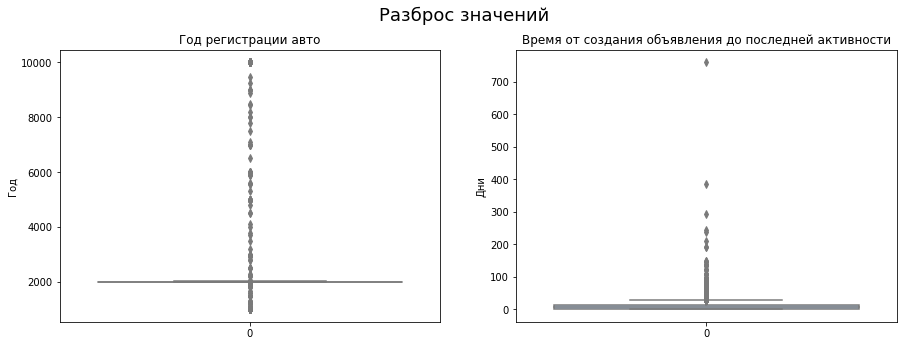

In [44]:
discr_col = ['RegistrationYear', 'days_from_first_to_last' ]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Разброс значений' , fontsize=18,  y=1)
box_for_nums(autos_new,discr_col)

axs[0].set_title("Год регистрации авто")
axs[0].set_ylabel("Год")

axs[1].set_title("Время от создания объявления до последней активности")
axs[1].set_ylabel('Дни');

In [45]:
autos_new.RegistrationYear.describe()

count    353866.000000
mean       2004.231899
std          89.927074
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [46]:
autos_new.RegistrationYear.value_counts().tail(10)

1931    1
1688    1
2200    1
1946    1
1949    1
4000    1
4100    1
5300    1
8888    1
2290    1
Name: RegistrationYear, dtype: int64

In [47]:
autos_new[(autos_new.RegistrationYear>=2016)|(autos_new.RegistrationYear<1940)].shape[0]

24285

- Среди значений года регистрации много аномальных значений. откуда-то взялись значения года невероятно позже 2016 года. Также есть авто датированные 1800-1900 годами.  Их около 14700 записей и их надо убрать (около 7% записей). 
- Большая часть авто зарегистрированы в 1999-2007 годах.

In [48]:
old_shape = autos_new.shape[0]
autos_new = autos_new[(autos_new.RegistrationYear<2016)&(autos_new.RegistrationYear>1940)]
print(f'Удалили {(old_shape - autos_new.shape[0])/old_shape*100} % записей')

Удалили 6.8633324478757505 % записей


In [49]:
autos_new.days_from_first_to_last.value_counts().head(10)

0    46337
2    35249
4    24639
1    19453
6    18620
3    16448
8    15328
9    11683
5    11458
7    11232
Name: days_from_first_to_last, dtype: int64

- В среднем, пользователь после размещения объявления проявляет активность вплоть до недели. 
Значение 0 может соответсвовать случаю, когда пользователь разместил объявление, но больше не посещал сервис или нашел покупателя в первый же день.

In [50]:
autos_new.PostalCode.value_counts().head(15)

10115    814
65428    561
66333    311
44145    289
52525    287
32257    287
38518    276
78224    271
60311    271
13357    267
51065    264
48249    258
52249    258
48599    258
50354    257
Name: PostalCode, dtype: int64

Значения почтового индекса разнообразны. Объявления размещали из разных регионов. Кажется, признак неинформативен для этого исследования.


### Вывод 
В ходе разведочного анализа:

1) было выяснено как распределены признаки среди всех объявлений.
    - В таблице представлены данные, в основном, за 2016 год.  В 2014 и 2015 годах - единичные объявления. Практически все объявления были сформированы в марте и апреле
    - В среднем, пользователь после размещения объявления проявляет активность на сервисе вплоть до недели. Правда, большАя часть пользователей проявляли активность последний раз в день создания объявления.
    - Стоимость авто в большинстве объявлений менее 7500 евро. Однако есть и сильно более дорогие авто.
    - В основном, продают машиныс механической коробкой передач и с кузовом типа *седан, хетчбек и фургон, с большим пробегом ~ 140000 км, с мощностью около 100 лошадиных сил. Большинство автомобилей работают на бензине и не были в ремонте.Среди наиболее популярных автомобилей - volkswagen, opel, bmw, в тч самая популярная модель - volkswagen golf.
    - Большая часть авто зарегистрированы в 1999-2007 годах.

2) Нашли и удалили аномальные значения в признаках: год регистрации авто (зарегистрированные ранее 1940 и позднее 2016 года), мощность авто (более 500 лс).

3) Рассмотрев все признаки, нашли неинформативные - **месяц регистрации, число фото в объявлении, почтовый индекс, дата скачивания анкеты из базы**. Они равномерно распределены среди объявлений (месяц регистрации) или не изменяются или не имеют логичной связи с ценообразованием на вторичном рынке авто.


## 4. Корреляционный анализ

Для оценки взаимосвязи признаков между собой и с целевым признаком - ценой построим матрицу корреляций Фи. 

Уберем неинформативные признаки.

In [51]:
autos_new = autos_new.drop(['PostalCode','DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen'], axis=1)
autos_new.sample()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated_month,days_from_first_to_last
34218,1250,small,1993,manual,17,other,60000,petrol,fiat,yes,3,0


In [52]:
corr_matrix = autos_new.phik_matrix(interval_cols=['Price', 'Kilometer', 'Power', 'days_from_first_to_last', 'RegistrationYear', 'DateCreated_month'])

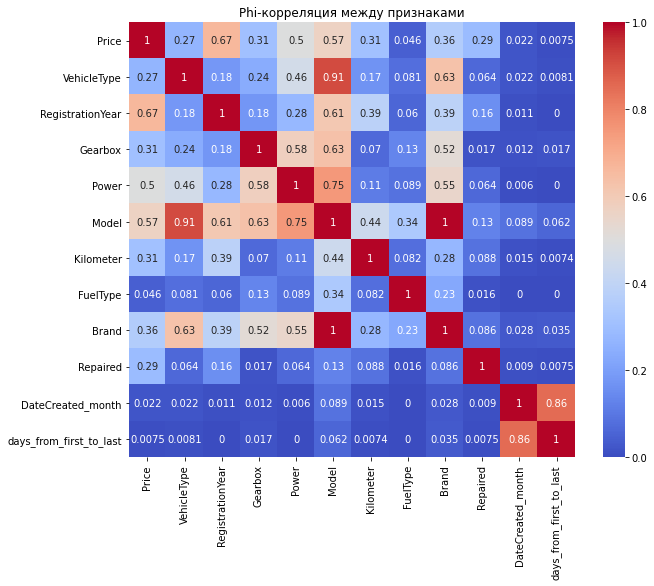

In [53]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi-корреляция между признаками')
plt.show();

### Вывод
Наиболее значимая систематическая закономерность существует между целевым признаком (Price) и:
- Годом регистрации авто
- Мощностью авто
- Моделью авто

В то же время, цена почти не зависит от даты создания объявления и периодом времени от создания объявления до полседней активности пользователя. Похоже, эти признаки тоже неинформативны.

- Модель авто значительно коррелирует с типом кузова (отчасти потому что мы заполняли пропуски в типе кузова модой в группах по моделям), с годом регистрации,с типом коробки передач, с мощностью. Это логично, потому что модель выпускают в определенный период, в ее особенности закладывают определенную мощность и тип коробки передач. Похожие корреляции показаны для марок авто.

## 5. Построение модели машинного обучения

Задача - построить модель, которая сможет предсказать стоимость автомобиля на основе данных из объявлений. Это задача регрессии.

Целевой признак - стоимость авто (Price).

Входные признаки - все остальные представленные в таблице `autos_new` (исключая неинформативные) : `VehicleType`, `RegistrationYear`, `Gearbox`, `Power`, `Model`, 	`Kilometer`,`FuelType`,	`Brand`, 	`Repaired`,	`DateCreated_month`,	`days_from_first_to_last`.

Модель должна соотвествовать требованию качества: 
- значение метрики RMSE должно быть меньше 2500 ;

Из моделей соответсвующих этому критерию качества надо выбрать *самые быстрые согласно времени обучения и времени предсказания.*

Сначала создадим пайплайн для подготовки данных, затем - итоговый пайплайн включающий модель.

Для решения задачи регрессии иcпользуем линейнуюю регрессию, регрессионное дерево решений и градиентный бустинг LigthGBM. Подберем из них более подходящую модель c учетом критериев.


Перед обучением закодируем категориальные признаки  с помощью OHE;

Масштабируем количественные данные (`RegistrationYear`,`Power`, `Kilometer`,`DateCreated_month`,`days_from_first_to_last`) с помощью StandardScaler. 

LigthGBM может использовать категориальные данные без кодирования (нужно передать категории в параметре categorical feature).


### 5.1 Подготовка данных


In [54]:
autos_new.sample()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated_month,days_from_first_to_last
195331,4000,suv,2005,manual,109,unknown,150000,petrol,land_rover,no,3,19


In [55]:
ohe_columns = ['Gearbox' , 'Repaired','VehicleType', 'Model', 'FuelType','Brand' ]
num_columns = ['RegistrationYear','Power', 'Kilometer','DateCreated_month','days_from_first_to_last']

In [56]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [57]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models',  Ridge(random_state=RANDOM_STATE))
    ]
)

### 5.2 Обучение 

#### Линейная модель

In [58]:
X = autos_new.drop(columns=['Price'])
y = autos_new.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [59]:
%%time
pipe_final.fit(X_train, y_train)

Wall time: 4.3 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gearbox', 'Repaired',
                                                   'VehicleType', 'Model',
                                                   'FuelType', 'Brand']),
                                                 ('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'DateCreated_month',
                                                   'days_from_first_to_last'])])),
                ('models', Ridge(random_state=42))])

In [60]:
%%time
y_pred = pipe_final.predict(X_train)

Wall time: 1.02 s


In [61]:
def ValidationScoreRMSE(model, X_train, y_train):
    return abs(cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error').mean())

In [62]:
ValidationScoreRMSE(pipe_final, X_train, y_train)

c:\Users\very-\practicum\practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


2747.650367251116

Линейная регрессия без настройки гиперпарматера:
- RMSE = 2747
- Время обучения = 4.82 с
- Время предсказания = 1.16 с

Попробуем улучшить результат подобрав гиперпараметры.

In [63]:
param_distributions = {
        'models__alpha': np.arange(0,3, 0.5),
}


In [64]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

print('Метрика RMSE для лучшей модели:\n', abs(randomized_search.best_score_))
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 


c:\Users\very-\practicum\practicum_env\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Метрика RMSE для лучшей модели:
 2747.6092122876416

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gearbox', 'Repaired',
                                                   'VehicleType', 'Model',
                                                   'FuelType', 'Brand']),
                                                 ('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'DateCreated_month',
                                                   'days_from_first_to_last'])])),


Подбор гиперпараметра - коэффициента регуляризации -  оказался неэффективен. Значение RMSE не возросло.

Перейдем от линейной регрессии к деревьям.




####  Дерево решений

Сразу подберем гиперпараметры

In [65]:
param_distributions = {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,15),
        'models__min_samples_split': range(2,10)
}


In [66]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['Gearbox',
                                                                                'Repaired',
                                                                                'VehicleType',
                                                                                'Model',
                                                                                'FuelType',
                                                                                'Brand']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['RegistrationYear',
                                                                                'Power',
                                                                                'Kilometer',
                                                                                'DateCreated_month',
                                                                                'days_from_first_to_last'])])),
                                             ('models',
                                              Ridge(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'models': [DecisionTreeRegressor(random_state=42)],
                                        'models__max_depth': range(2, 15),
                                        'models__min_samples_split': range(2, 10)},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [67]:
print('Метрика RMSE для лучшей модели:\n', abs(randomized_search.best_score_))
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика RMSE для лучшей модели:
 1990.8941137289687

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gearbox', 'Repaired',
                                                   'VehicleType', 'Model',
                                                   'FuelType', 'Brand']),
                                                 ('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'DateCreated_month',
                                                   'days_from_first_to_last'])])),


Мы нашли модель, которая подходит под критерий качества.  Оценим время обучения и предсказания.

In [68]:
tree = randomized_search.best_estimator_


In [69]:
%%time
tree.fit(X_train, y_train)

Wall time: 12.4 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gearbox', 'Repaired',
                                                   'VehicleType', 'Model',
                                                   'FuelType', 'Brand']),
                                                 ('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'DateCreated_month',
                                                   'days_from_first_to_last'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=13, min_samples_split=7,
                                       random_state=42))])

In [70]:
%%time
y_pred = tree.predict(X_train)

Wall time: 781 ms


C помощью рандомизированного поиска с кроссвалидацией удалось найти модель соответсвующую критерию качества (RMSE<2500) :  
- RMSE = 1990 
- Время обучения = 12.4 с
- Время предсказания = 781 мс

Теперь попробуем использовать градиентный бустинг LightGBM.


#### Градиентный бустинг LightGBM

Сначала посмотрим на модель без подбора гиперпараметров.


In [71]:
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand','Repaired']
for feature in categorical_features:
    X[feature] = X[feature].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)


In [72]:
model = lgb.LGBMRegressor()

In [73]:
%%time
model.fit(X_train, y_train)

Wall time: 1.92 s


LGBMRegressor()

In [74]:
%%time
y_pred = model.predict(X_train)

Wall time: 886 ms


In [75]:
ValidationScoreRMSE(model, X_train, y_train)

1710.023715741283

Дефолтный градиентный бустинг показывает хорошие результаты:
- RMSE = 1710
- Время обучения = 3.0 с
- Время предсказания = 871 мс

Все показатели лучше чем при использовании линейной регрессии и дерева решений.

Попробуем дополнительно улучшить качество градиентного бустинга подбором гиперпараметров.


In [76]:
param_distributions = {
        'learning_rate': np.arange(0.1, 0.5, 0.1),
        'max_depth': range(2,10),
        'n_estimators': range(50,100, 10)
}

In [77]:
randomized_search = RandomizedSearchCV(
    model, 
    param_distributions=param_distributions, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

RandomizedSearchCV(estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4]),
                                        'max_depth': range(2, 10),
                                        'n_estimators': range(50, 100, 10)},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [78]:
print('Метрика RMSE для лучшей модели:\n', abs(randomized_search.best_score_))
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика RMSE для лучшей модели:
 1691.5657699168648

Лучшая модель и её параметры:

 LGBMRegressor(learning_rate=0.30000000000000004, max_depth=7, n_estimators=80)


In [79]:
gbm = randomized_search.best_estimator_

In [80]:
%%time
gbm.fit(X_train, y_train)

Wall time: 1.42 s


LGBMRegressor(learning_rate=0.30000000000000004, max_depth=7, n_estimators=80)

In [81]:
%%time
y_pred = gbm.predict(X_train)

Wall time: 771 ms


Градиентный бустинг с подобранными параметрами чуть лучше и чуть быстрее работает чем все ранее рассмотренные модели:
- RMSE = 1693
- Время обучения = 1.71 с
- Время предсказания = 676 мс


Лучшая модель из рассмотренных по качеству и скорости обучения и предсказания - градиентный бустинг LGBMRegressor(learning_rate=0.3, max_depth=7, n_estimators=80). Для него посчитаем итоговую метрику на тестовой выборке.

In [82]:
y_pred = gbm.predict(X_test)
print(f'Итоговое значение метрики качества RMSE на тестовой выборке для лучшей модели - градиентного бустинга {round(mean_squared_error(y_test, y_pred, squared=False),2)}')

Итоговое значение метрики качества RMSE на тестовой выборке для лучшей модели - градиентного бустинга 1684.28


### Вывод

При создании модели предсказания стоимости автомобиля на основании, в первую очередь, характеристик машин, проверили качество (метрикой RMSE) и время работы классических моделей (линейные модели, дерево решений) и градиентного бустинга LightGBM с подбором гиперпараметров. 

- базовая линейная регрессия с l2 регуляризацией показала результат: **RMSE = 2747 Время обучения = 4.82 с Время предсказания = 1.16 с**
- подбор гиперпараметра для линейной регрессия с l2 не способствовал увеличению качества модели, в любом случае, данная модель не подходит под критерий качества

- дерево решений с подобранными гиперпараметрами (max_depth=13, min_samples_split = 7)  имело такой результат: **RMSE = 1990  Время обучения = 12.4 с  Время предсказания = 781 мс.** Это решение подходит под критерий качества.

- дефолтный градиентный бустинг LightGBM показал результат по трем параметрам лучше, чем предыдущие модели. **RMSE = 1710 Время обучения = 3.0 с Время предсказания = 871 мс**
- градиентный бустинг LightGBM с подобранными параметрами (learning_rate=0.3, max_depth=7, n_estimators=80) оказался еще немного лучше - **RMSE = 1693 Время обучения = 1.71 с  Время предсказания = 676 мс**


Таким образом, согласно критерию по качеству и по скорости обучения и предсказания, выбираем лучшей моделью для данной задачи **LGBMRegressor(learning_rate=0.3, max_depth=7, n_estimators=80)**. Ее качество на тестовой выборке RMSE = 1684. 



## 6. Итоговый вывод

**1. Обзор данных**

- Для исследования была предоставлена таблица `autos.csv` с 16 параметрами автомобилей и собственно объявлений и 354369 записями. Данные соответствуют описанию задачи.
- В пяти колонках таблицы есть пропуски , их существенное количество : более 10% от всех записей. Это наводит на мысль, что есть недочеты в системе сбора данных. Вероятно в анкетах практичекски любое поле можно пропустить и не заполнять, отсюда большое количество пропусков. Этот момент могут скорректировать разработчики сервиса.

- Заметили, что `NumberOfPictures` неинформативный признак , т.к. среди представленных для анализа данных он не изменяется - для всех записей значение 0. Его удалили.
- В колонке с годом регистрации есть аномальные невозможные значения (9999, 1000 и другие).

**2. Предобработка**

*Пропуски:*

-  в колонке с типом кузова заменили на самые распространенные значения в группах по модели машины.
-  в колонках с типом коробки передач, с моделью авто заполнили категорией `unknown`
-  в колонке с инфо о проведении ремонта авто заполнили категорией `no`
-  в колонке с типом топлива отнесли к самой распространенной категории `petrol`

*Дубликаты и ошибки:*
- в колонке с типом топлива убрали категорию  gasoline, и отнесли сооответвующие записи к категории petrol. 
- удалили строки-дубликаты

*Также:*
- Изменили тип данных дат на  `datetime`
- Добавили колонки с месяцем появления объявления и днями между появлением объявления и последней активностью пользователя,т.к они могут косвенно связаны со стоимостью авто (спрос может меняться в разные месяцы года, и чем адекватнее цена, тем быстрее происходит покупка)

**3. Разведочный анализ**

- В ходе EDA узнали следующее:
    - В таблице представлены данные, в основном, за 2016 год.  В 2014 и 2015 годах - единичные объявления. Практически все объявления были сформированы в марте и апреле
    - В среднем, пользователь после размещения объявления проявляет активность на сервисе вплоть до недели. Правда, большАя часть пользователей проявляли активность последний раз в день создания объявления.
    - Стоимость авто в большинстве объявлений менее 7500 евро. 
    - В основном, продают машины с механической коробкой передач и с кузовом типа *седан, хетчбек и фургон, с большим пробегом ~ 140000 км, с мощностью около 100 лошадиных сил. Большинство автомобилей работают на бензине и не были в ремонте.Среди наиболее популярных автомобилей - volkswagen, opel, bmw, в тч самая популярная модель - volkswagen golf.
    - Большая часть авто зарегистрированы в 1999-2007 годах.

- Нашли и удалили аномальные значения в признаках: год регистрации авто (зарегистрированные ранее 1940 и позднее 2016 года), мощность авто (более 500 лс).

- Рассмотрев все признаки, нашли неинформативные - **месяц регистрации, число фото в объявлении, почтовый индекс, дата скачивания анкеты из базы**. Они равномерно распределены среди объявлений (месяц регистрации) или не изменяются или не имеют логичной связи с ценообразованием на вторичном рынке авто.

**4. Корреляционный анализ**

На матрице корреляций Фи заметили, что наиболее значимая систематическая закономерность существует между целевым признаком (Price) и:
- Годом регистрации авто
- Мощностью авто
- Моделью авто

В то же время, цена почти не зависит от даты создания объявления и периодом времени от создания объявления до полседней активности пользователя. Похоже, эти признаки оказались не особо неинформативны.

**5. Обучение моделей и предсказание**

При создании модели предсказания стоимости автомобиля на основании, в первую очередь, характеристик машин, проверили качество (метрикой RMSE) и время работы классических моделей (линейные модели, дерево решений) и градиентного бустинга LightGBM с подбором гиперпараметров. 

- базовая линейная регрессия с l2 регуляризацией показала результат: **RMSE = 2747 Время обучения = 4.82 с Время предсказания = 1.16 с**
- подбор гиперпараметра для линейной регрессия с l2 не способствовал увеличению качества модели, в любом случае, данная модель не подходит под критерий качества

- дерево решений с подобранными гиперпараметрами (max_depth=13, min_samples_split = 7)  имело такой результат: **RMSE = 1990  Время обучения = 12.4 с  Время предсказания = 781 мс.** Это решение подходит под критерий качества.

- дефолтный градиентный бустинг LightGBM показал результат по трем параметрам лучше, чем предыдущие модели. **RMSE = 1710 Время обучения = 3.0 с Время предсказания = 871 мс**
- градиентный бустинг LightGBM с подобранными параметрами (learning_rate=0.3, max_depth=7, n_estimators=80) оказался еще немного лучше - **RMSE = 1693 Время обучения = 1.71 с  Время предсказания = 676 мс**


Таким образом, согласно критерию по качеству и по скорости обучения и предсказания, выбираем лучшей моделью для данной задачи **LGBMRegressor(learning_rate=0.3, max_depth=7, n_estimators=80)**. Ее качество на тестовой выборке RMSE = 1684. 

